![](images/2022-12-14-pytorch-autoencoder.png)

## Credits
This notebook takes inspiration and ideas from the following sources.

* [Introduction to Deep Learning](https://sebastianraschka.com/blog/2021/dl-course.html) course by [Sebastian Raschka](https://twitter.com/rasbt). Sebastian is one of my favorite instructors. You can find all his lectures free on his YouTube channel, with tons of practice material he regularly shares on his blog. Lectures I find helpful on this topic include [L16 AutoEncoder](https://sebastianraschka.com/blog/2021/dl-course.html#l16-autoencoders). Parts of the code in this notebook are taken from his course material.
  * [L16.0 Introduction to Autoencoders – Lecture Overview](https://www.youtube.com/watch?v=9Ujv_IoBtF4)
  * [L16.1 Dimensionality Reduction](https://www.youtube.com/watch?v=UgOHupaIfcA)
  * [L16.2 A Fully-Connected Autoencoder](https://www.youtube.com/watch?v=8O_FDPIlj1s)
  * [L16.3 Convolutional Autoencoders & Transposed Convolutions](https://www.youtube.com/watch?v=ilkSwsggSNM)
  * [L16.4 A Convolutional Autoencoder in PyTorch](https://www.youtube.com/watch?v=345wRyqKkQ0)
  * [L16.5 Other Types of Autoencoders](https://www.youtube.com/watch?v=FPZeRM1p1ao)
  * [Notebook: 1_VAE_mnist_sigmoid_mse.ipynb](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/1_VAE_mnist_sigmoid_mse.ipynb)
* [Modern Computer Vision with PyTorch](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch) book published by Packt has tons of useful material on its GitHub repository. [Chapter 11](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/tree/master/Chapter11) from this book is related to AutoEncoder. Parts of the code you see in this notebook are taken from the following notebooks.
  * [Notebook: simple_auto_encoder_with_different_latent_size.ipynb](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/simple_auto_encoder_with_different_latent_size.ipynb)
  * [Notebook: conv_auto_encoder.ipynb](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/conv_auto_encoder.ipynb)

## Environment
This notebook is prepared with Google Colab.

* **GitHub**: [2022-12-14-pytorch-autoencoder.ipynb](https://github.com/hassaanbinaslam/myblog/blob/main/posts/2022-12-14-pytorch-autoencoder.ipynb)
* **Open In Colab**: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hassaanbinaslam/myblog/blob/main/posts/2022-12-14-pytorch-autoencoder.ipynb)

In [1]:
#| code-fold: true
from platform import python_version
import numpy, matplotlib, pandas, torch

print("python==" + python_version())
print("numpy==" + numpy.__version__)
print("torch==" + torch.__version__)
print("matplotlib==" + matplotlib.__version__)

python==3.8.16
numpy==1.21.6
torch==1.13.0+cu116
matplotlib==3.2.2


Let's also set the device and seed for results reproducibility.

In [2]:
# | code-fold: true
import torch, os, random
import numpy as np

# https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed

    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
set_seed()

Device: cuda
Random seed set as 42


## Introduction
> Following is the `AutoEncoder` explanation provided by [OpenAI ChatGPT](https://chat.openai.com/chat). If unsatisfied, I suggest using the links provided in the "Credits" section ([L16.0 Introduction to Autoencoders by Sebastian Raschka](https://jalammar.github.io/illustrated-word2vec/))

`prompt > introduction to autoencoder`

**AutoEncoder**

An autoencoder is a type of artificial neural network that is used to learn efficient data codings in an unsupervised manner. Autoencoders are composed of two parts: an encoder and a decoder. The encoder takes in an input and converts it into a compressed representation, typically in the form of a lower-dimensional code. The decoder then takes this code and converts it back into a reconstruction of the original input.

The goal of an autoencoder is to learn a representation of the input data that is more efficient than the original input. This is achieved by training the network to reconstruct the input from the lower-dimensional code, which forces the encoder to learn a compact representation of the data. Autoencoders can be used for dimensionality reduction, feature learning, and generating new data samples.

![Figure 1: A basic fully connected AutoEncoder](./images/2022-12-14-pytorch-autoencoder/autoencoder.png)

From these descriptions, we can deduce the following points about an autoencoder working. 

* An autoencoder can learn a compact representation of the data. This representation is stored in the center hidden layer of the network. We have multiple names for this center hidden layer, including `bottleneck`, `latent space`, `embedded space`, and `hidden units`.
* The latent space has a dimension less than the input data dimension.
* Autoencoder can be used for dimensionality reduction. In fact, if we don't use any non-linearity (e.g., ReLU) then autoencoder will function similarly to PCA since PCA is a linear dimensionality reduction method.
* Encoder part of the autoencoder model compresses the data to a latent space. The decoder can use the latent space to reconstruct (or decode) the original image.

**Summary of the steps followed in this notebook**

* Download [MNIST handwritten digit](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html) dataset
* Train an autoencoder with 2-dimensional (2 pixels) latent space. Use 2 pixels to deconstruct the whole MNIST digit image. Visualize the latent space learned by the model. Use random latent space points to decode the images 
* Create multiple autoencoders with varying latent space [2, 5, 10, 20, 50] and use them to decode the images. Compare the results to analyze the effect of latent dimension in storing information and decoded image quality. 
* Visualize the latent space of the model with a latent space of 50 dimensions. Use random points from the latent space to decode (or construct new) images.
* Finally, discuss the limitations of autoencoders.

## Data Preparation

### Load MNIST Dataset

In the next cell, I downloaded the MNIST dataset and created a DataLoader with a batch size of 256.

In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 256

train_dataset = datasets.MNIST(
    root="data", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(root="data", train=False, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Notice that while creating `Datasets,` I used a transformer `transform=transforms.ToTensor()`. [torchvision.transforms.ToTensor.html](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)

> [transforms.ToTensor] Convert a PIL Image or numpy.ndarray to tensor ... Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

So it manipulates the MNSIT images in two ways

* Converts image dimensions from (H x W x C) to (C x H x W)
* Scales image pixel values from the range [0, 255] to range [0.0, 1.0]

Let's check the dimension of our dataset.

In [4]:
for images, labels in train_loader:
    print(
        "Image batch dimensions:", images.shape
    )  # [batch size, channels, img height, img width]
    print("Image label dimensions:", labels.shape)  # [batch size]
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


## Model configuration
Let's configure a simple AutoEncoder model. It is made of two fully connected multilayer perceptrons. The first perceptron will gradually decrease the dimensions of the input data till it reaches the latent dimension size. The second perceptron will gradually increase the dimensions of data obtained from latent space till it reaches the input size. Notice that

* Latent space dimension (`latent_dim`) is kept configurable so we can use the same model class to configure autoencoder having different latent spaces
* I have used `torch.sigmoid()` in the forward pass. This is to squash the data into the range [0, 1]. This is done because the input image received by the model is assumed to be in this range (remember `transforms.ToTensor()` function while creating datasets). So we want the image created (or returned) by the model to be in the same distribution range.

In [5]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, num_features, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, num_features),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x

## AutoEncoder with latent space dimension=2
Let's create our first autoencoder with a latent space of 2 features. This means we will compress our input image of `28*28=784` features to only two in the latent space. Then we will use the information stored in these two features to reconstruct (or decode) the full image having 784 features. Why only two features for the latent space?

* We want to try an extreme case, and you will be surprised to see that even with two features in latent space, we can construct the whole image with acceptable quality.
* We want to visualize the 2D latent space. Visualizing (plotting) latent space with higher dimensions will not be possible.

In [6]:
learning_rate = 0.005
num_features = 28 * 28  # image height X image width = 784
latent_dim = 2

model = AutoEncoder(num_features, latent_dim)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

We have configured our model and optimizer, and we can start training our model.

In [7]:
import time
import torch.nn.functional as F

num_epochs = 10
start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        # don't need labels, only the images (features)
        features = features.view(-1, num_features).to(device)

        ### FORWARD AND BACK PROP
        decoded = model(features)
        loss = F.mse_loss(decoded, features)
        optimizer.zero_grad()

        loss.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print(
                "Epoch: %03d/%03d | Batch %03d/%03d | Training Loss: %.4f"
                % (epoch + 1, num_epochs, batch_idx, len(train_loader), loss)
            )

print("Total Training Time: %.2f min" % ((time.time() - start_time) / 60))

Epoch: 001/010 | Batch 000/235 | Training Loss: 0.2315
Epoch: 001/010 | Batch 050/235 | Training Loss: 0.0655
Epoch: 001/010 | Batch 100/235 | Training Loss: 0.0523
Epoch: 001/010 | Batch 150/235 | Training Loss: 0.0517
Epoch: 001/010 | Batch 200/235 | Training Loss: 0.0511
Epoch: 002/010 | Batch 000/235 | Training Loss: 0.0479
Epoch: 002/010 | Batch 050/235 | Training Loss: 0.0486
Epoch: 002/010 | Batch 100/235 | Training Loss: 0.0441
Epoch: 002/010 | Batch 150/235 | Training Loss: 0.0456
Epoch: 002/010 | Batch 200/235 | Training Loss: 0.0461
Epoch: 003/010 | Batch 000/235 | Training Loss: 0.0438
Epoch: 003/010 | Batch 050/235 | Training Loss: 0.0460
Epoch: 003/010 | Batch 100/235 | Training Loss: 0.0423
Epoch: 003/010 | Batch 150/235 | Training Loss: 0.0442
Epoch: 003/010 | Batch 200/235 | Training Loss: 0.0439
Epoch: 004/010 | Batch 000/235 | Training Loss: 0.0415
Epoch: 004/010 | Batch 050/235 | Training Loss: 0.0447
Epoch: 004/010 | Batch 100/235 | Training Loss: 0.0411
Epoch: 004

Note that in the above training loop.

* `features` = input images
* `decoded` = decoded or reconstructed images from latent space. This is because it runs the forward pass when we predict from our model (`decoded = model(features)`). And we know that during the forward pass, we will first encode the input image, then use the output (latent representation) to reconstruct the image using the decoder.

Let's plot these original images and decoded ones to see how much we are successful in doing that.

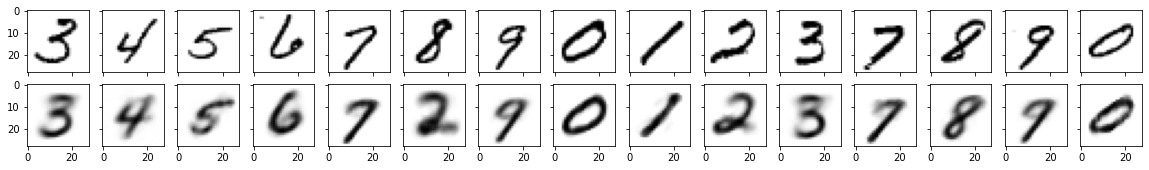

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))

orig_images = features[:n_images]
decoded_images = decoded[:n_images]
label_images = targets[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

These results are remarkable, considering we only use information from two pixels to generate a complete image of 784 pixels. So what information is stored in those two pixels (embedding)? Let's also print embeddings for the above generated images.

In [9]:
for feature, target in zip(orig_images, label_images):
    feature = feature.view(-1, num_features).to(device)
    with torch.no_grad():
        embedding = model.encoder(feature)

    print(f"Label: {target}, Embedding: {embedding.cpu().numpy()}")

Label: 3, Embedding: [[-1.6004068  -0.96022624]]
Label: 4, Embedding: [[3.5773783 1.7578685]]
Label: 5, Embedding: [[ 9.145074 -2.872149]]
Label: 6, Embedding: [[ 1.7183754 -2.08906  ]]
Label: 7, Embedding: [[10.19044   9.111174]]
Label: 8, Embedding: [[-2.115856   1.4071143]]
Label: 9, Embedding: [[6.411824  5.6826334]]
Label: 0, Embedding: [[  8.0015   -13.730832]]
Label: 1, Embedding: [[-7.0476646  6.571097 ]]
Label: 2, Embedding: [[-5.4590693  2.0496612]]
Label: 3, Embedding: [[-1.0255219 -0.9620053]]
Label: 4, Embedding: [[14.75902   7.228238]]
Label: 8, Embedding: [[14.938157   -0.26024085]]
Label: 9, Embedding: [[8.782047 6.697904]]
Label: 0, Embedding: [[ 13.757708 -11.047596]]


By analyzing these values, we can say that our autoencoder has learned to use slightly different ranges for embeddings each of the digits. Next, let's try to visualize the distribution of latent space for the complete training set. For this, I have used a helper function. This function creates scatter plots of the latent space for all the digits.

In [10]:
import numpy as np
import matplotlib.colors as mcolors

# https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/helper_plotting.py
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn, device):
    d = {i: [] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.view(-1, num_features).to(device)
            targets = targets.to(device)

            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to("cpu").numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    plt.figure(figsize=(8, 8))
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])

        plt.scatter(d[i][:, 0], d[i][:, 1], color=colors[i][1], label=f"{i}", alpha=0.5)

    plt.legend()

Let’s create the plot.

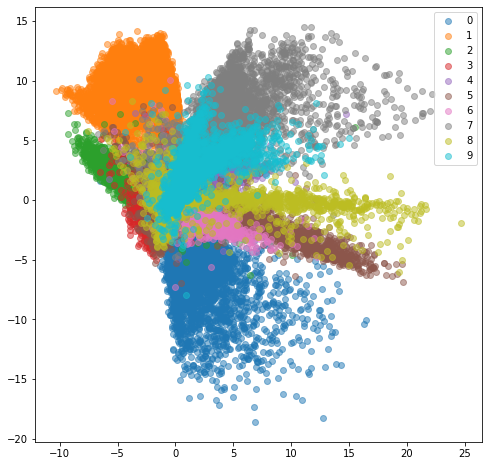

In [11]:
plot_latent_space_with_labels(
    num_classes=len(train_dataset.classes),  # 10
    data_loader=train_loader,
    encoding_fn=model.encoder,
    device=device,
)

plt.legend()
plt.show()

This plot tells us different digits are occupying different areas in the latent space. If we want to draw a sample for a number (e.g., 0), we must take the point from its range. It is a 2D plot, so If I take a sample from it, I will get two points (x, y), and then I can use that as an embedding. I can then reconstruct an image using the `decoder` of my model from this embedding.

In the next cell, I have created a helper function that can take the embeddings list and decode an image from it.

In [12]:
def decode_images(model, embedding_list):
    fig, axs = plt.subplots(1, len(embedding_list), figsize=(20, 2.5))

    for i, (label, embedding) in enumerate(embedding_list):
        with torch.no_grad():
            new_image = model.decoder(torch.tensor(embedding).to(device))

        new_image = torch.sigmoid(new_image)
        new_image = new_image.view(28, 28)
        new_image = new_image.detach().to(torch.device("cpu"))

        axs[i].set_title(label)
        axs[i].imshow(new_image, cmap="binary")

    plt.show()

Next, I created some embeddings using the above plot.

In [13]:
embedding_list = [
    ("0", [5.0, -10.0]),
    ("1", [-4.0, 13.0]),
    ("2", [-5.4, 2.0]),
    ("2 overlap with 3", [-4.0, 0.0]),
    ("3 ouside sample space", [-5.0, -5.0]),
    ("7", [6.0, 11.0]),
    ("9 overlap with 8", [0.0, 0.0]),
    ("5", [9.0, -3.0]),
]

Let's use these embeddings to generate some images. Note a few points.

* There are no clear boundaries between the digits' latent space
* If you select a point that is on the edge or at the boundary of the space, then you may get a more distorted image
    * Digit 2 image that has some overlap with digit 3
    * Digit 9 image that has some overlap with 8
* There is no definite range of the latent space
    * Digit 3 image generated from the embedding range not visible in the plot

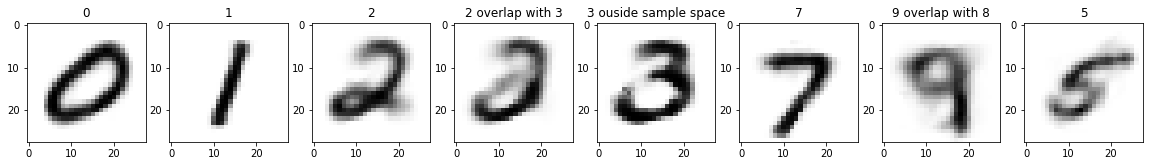

In [14]:
decode_images(model, embedding_list)

## AutoEncoder with latent space dimension=[5, 10, 20, 50]
We have seen the quality of decoded images from 2d latent space. Our understanding is that if we increase the dimension, it will retain more information and improve the image quality.

Next, I have created a function that can take a model to train it. We will iteratively create models with increasing dimensions and use this function to train them.

In [15]:
def training_loop(train_loader, model, optimizer, device, num_epochs=10):
    start_time = time.time()
    for epoch in range(num_epochs):
        for batch_idx, (features, targets) in enumerate(train_loader):
            # don't need labels, only the images (features)
            features = features.view(-1, num_features).to(device)

            ### FORWARD AND BACK PROP
            decoded = model(features)
            loss = F.mse_loss(decoded, features)
            optimizer.zero_grad()

            loss.backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

        ### LOGGING
        print("Epoch: %03d | Training Loss: %.4f" % (epoch + 1, loss))

    print("Total Training Time: %.2f min" % ((time.time() - start_time) / 60))

In [16]:
models_list = [model]  # model with latent_dim=2
latent_dimensions = [5, 10, 20, 50]

for latent_dim in latent_dimensions:
    model_n = AutoEncoder(num_features, latent_dim)
    model_n = model_n.to(device)
    optimizer_n = torch.optim.Adam(model_n.parameters(), lr=learning_rate)
    models_list.append(model_n)

    print(f"\n*** Training AutoEncoder with latent_dim={latent_dim} ***\n")
    training_loop(train_loader, model_n, optimizer_n, device)


*** Training AutoEncoder with latent_dim=5 ***

Epoch: 001 | Training Loss: 0.0396
Epoch: 002 | Training Loss: 0.0315
Epoch: 003 | Training Loss: 0.0292
Epoch: 004 | Training Loss: 0.0278
Epoch: 005 | Training Loss: 0.0270
Epoch: 006 | Training Loss: 0.0262
Epoch: 007 | Training Loss: 0.0256
Epoch: 008 | Training Loss: 0.0251
Epoch: 009 | Training Loss: 0.0248
Epoch: 010 | Training Loss: 0.0247
Total Training Time: 0.92 min

*** Training AutoEncoder with latent_dim=10 ***

Epoch: 001 | Training Loss: 0.0372
Epoch: 002 | Training Loss: 0.0279
Epoch: 003 | Training Loss: 0.0235
Epoch: 004 | Training Loss: 0.0209
Epoch: 005 | Training Loss: 0.0194
Epoch: 006 | Training Loss: 0.0186
Epoch: 007 | Training Loss: 0.0180
Epoch: 008 | Training Loss: 0.0176
Epoch: 009 | Training Loss: 0.0175
Epoch: 010 | Training Loss: 0.0170
Total Training Time: 0.90 min

*** Training AutoEncoder with latent_dim=20 ***

Epoch: 001 | Training Loss: 0.0392
Epoch: 002 | Training Loss: 0.0290
Epoch: 003 | Training

Verify the latent space dimension of our models.

In [17]:
for model_n in models_list:
    print(model_n.latent_dim)

2
5
10
20
50


Next, we will compare the results from these models. This time I have used the test dataset that our model has not seen. From the results, you may note that the results from the models with latent_dim 2 and 5 are blurry and make mistakes while decoding the input image. In comparison, the results from the rest are more accurate and of better quality.

It also tells us that we can significantly compress the images without losing much information. For example, our `model_50` (model with latent_dim=50) can generate an original image with 16x less information. But this performance also depends on the type of images used. For example, we have black-and-white digit images with large white spaces, so we were able to compress them significantly. On the other hand, we may get different performances with images having more patterns.

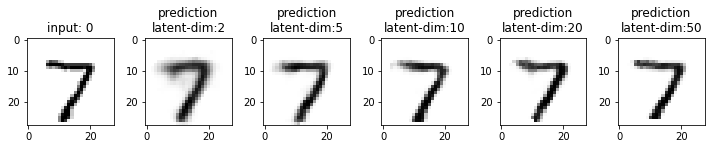

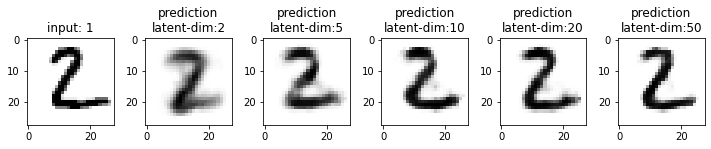

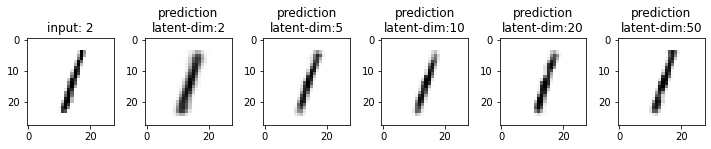

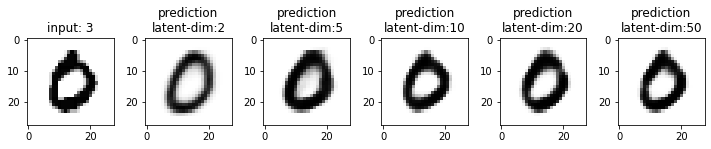

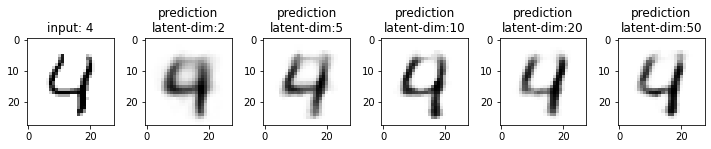

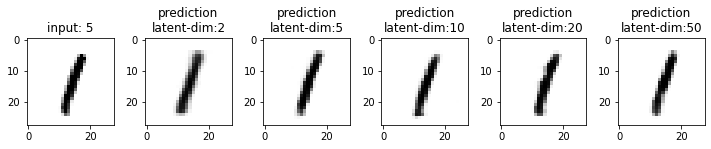

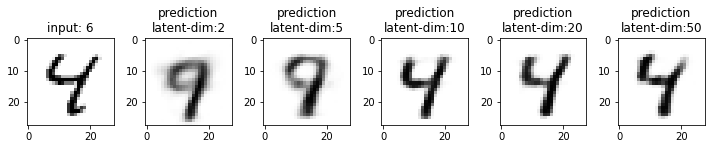

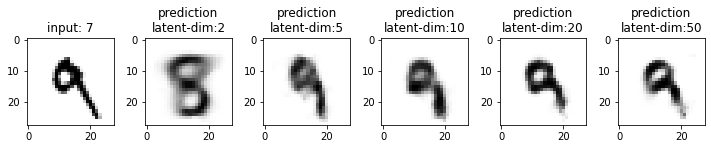

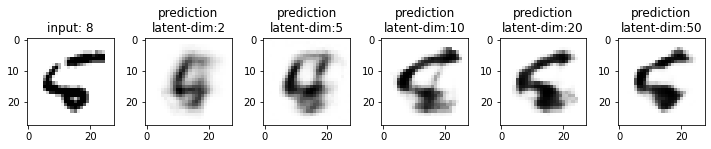

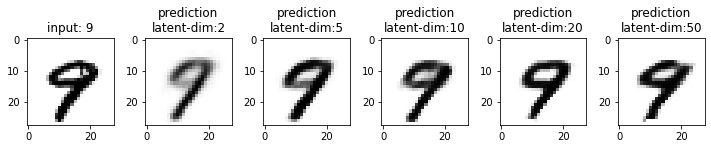

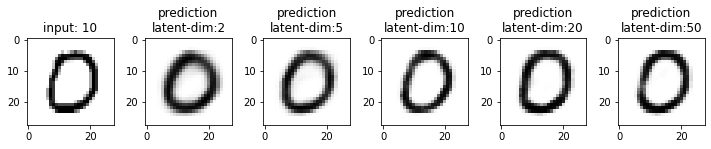

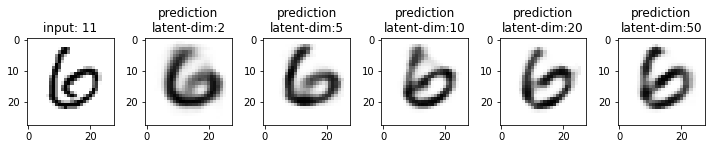

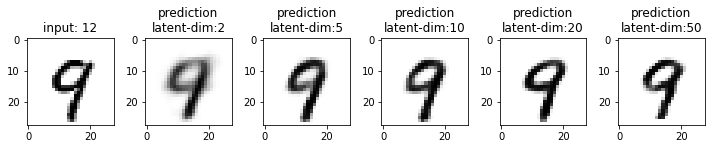

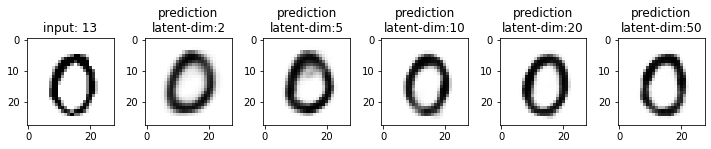

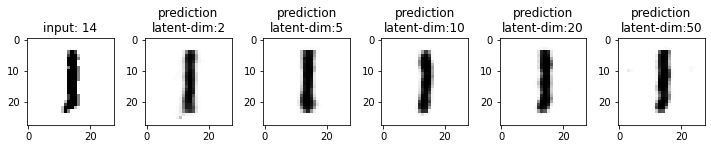

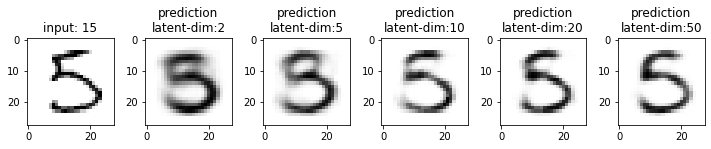

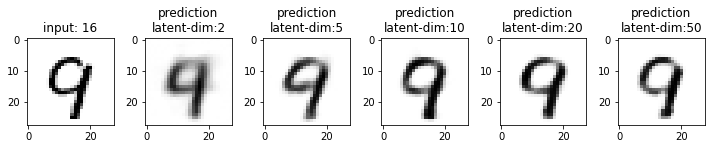

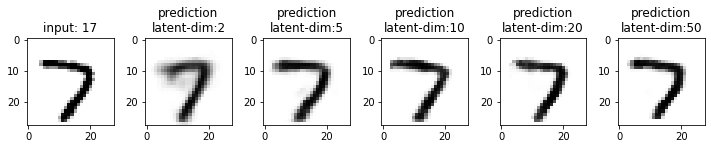

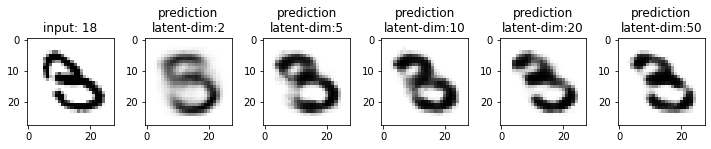

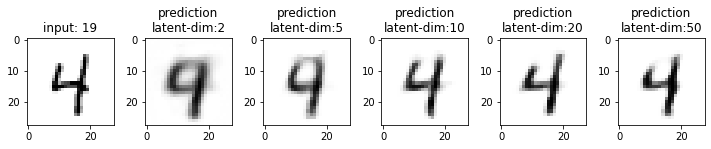

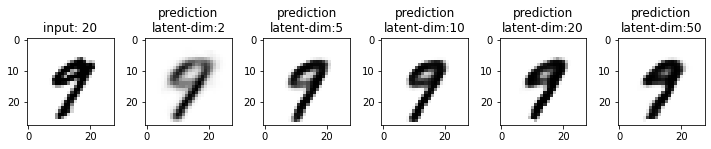

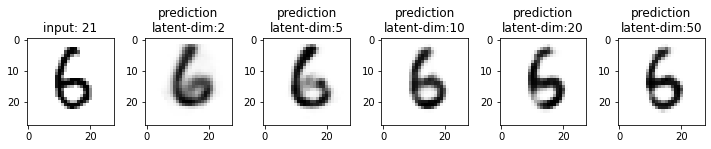

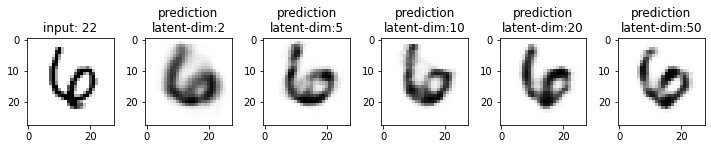

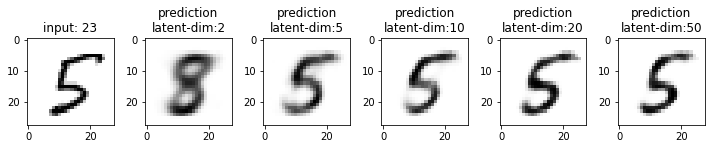

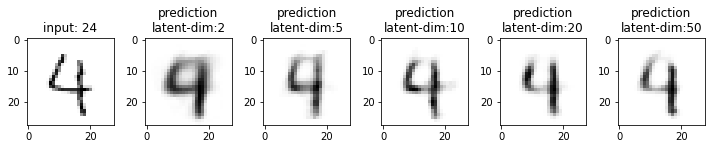

In [18]:
img_sample_count = 25

for idx in range(img_sample_count):
    # get an image from test_dataset
    input_img, _ = test_dataset[idx]
    # flatten the image
    input_img = input_img.view(-1, num_features).to(device)

    fig, ax = plt.subplots(1, len(models_list) + 1, figsize=(10, 4))

    # iterate over all the models list
    for i, model_n in enumerate(models_list):
        # put the model in eval mode to stop accumulating gradients
        model_n.eval()
        # make a prediction
        decoded_img = model_n(input_img)
        # squach the prediction between [0,1]
        decoded_img = torch.sigmoid(decoded_img)
        # detach the prediction and convert back to 28,28 shape
        decoded_img = decoded_img.detach().to(torch.device("cpu"))
        decoded_img = decoded_img.view(28, 28)

        ax[i + 1].set_title(f"prediction\nlatent-dim:{model_n.latent_dim}")
        ax[i + 1].imshow(decoded_img, cmap="binary")

    # plot the input image
    ax[0].set_title(f"input: {idx}")
    input_img = input_img.detach().to(torch.device("cpu"))
    input_img = input_img.view(28, 28)
    ax[0].imshow(input_img, cmap="binary")

    plt.tight_layout()
    plt.show()

From model_50, we are getting considerably good results compared to model_2 and model_5. The last time we visualized the embeddings for model_2, we also found that the latent space of digits was overlapping. Since the output quality of model_50 has improved, the overlap in the latent space should be less. Let's confirm this assumption.

For this, we will first gather the embeddings of the test images. Remember that the output from the `model.encoder` is the embedding of an image (or compressed representation).

In [19]:
latent_vectors = []
classes = []
model_50 = models_list[-1]

print("model_50 latent_dim: ", model_50.latent_dim)

model_50 latent_dim:  50


In the next cell, I am collecting the embeddings. Note that each fetch from the DataLoader iterator returns a batch of images (batch_size=256).

In [20]:
for images_batch,labels_batch in test_loader:
    # images_batch.shape = torch.Size([256, 1, 28, 28]
    # labels_batch.shape = torch.Size([256])
    # images_batch.view(-1, num_features).shape = torch.Size([256, 784])
    # encoded_batch.shape =torch.Size([256, 50])

    images_batch = images_batch.view(-1, num_features).to(device)
    encoded_batch = model_50.encoder(images_batch)

    latent_vectors.append(encoded_batch)
    classes.extend(labels_batch)    

Let's confirm the dimensions.

* `len(latent_vectors) = 40`. It means we have 40 latent vectors. Each vector holds the embeddings for a batch of images
* `latent_vectors[0].shape = torch.Size([256, 50]`. It means that each latent vector holds embeddings of size 50 for a batch of 256 images
* `torch.cat(latent_vectors).shape = torch.Size([10000, 50])`. It means that if we concatenate the embeddings of all the images, we will have a tensor of 10,000 rows with 50 dimensions (or features/columns)

In [21]:
len(latent_vectors), latent_vectors[0].shape, torch.cat(latent_vectors).shape

(40, torch.Size([256, 50]), torch.Size([10000, 50]))

In [22]:
# concatenate all test images embeddings
latent_vectors_cat = torch.cat(latent_vectors).cpu().detach().numpy()
latent_vectors_cat.shape

(10000, 50)

Now that we have all the embeddings, we can visualize them too. But how can we visualize embeddings with 50 features? We can use [sklearn.manifold.TSNE.html](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

`chatGPT prompt > explain T-distributed Stochastic Neighbor Embedding` 

T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm that is used to reduce the dimensionality of high-dimensional data and visualize it in a lower-dimensional space. It works by measuring the similarity between the data points and representing them as points in a lower-dimensional space, such that similar data points are grouped together, and dissimilar ones are separated. This allows for better visualization and understanding of the structure of the data.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


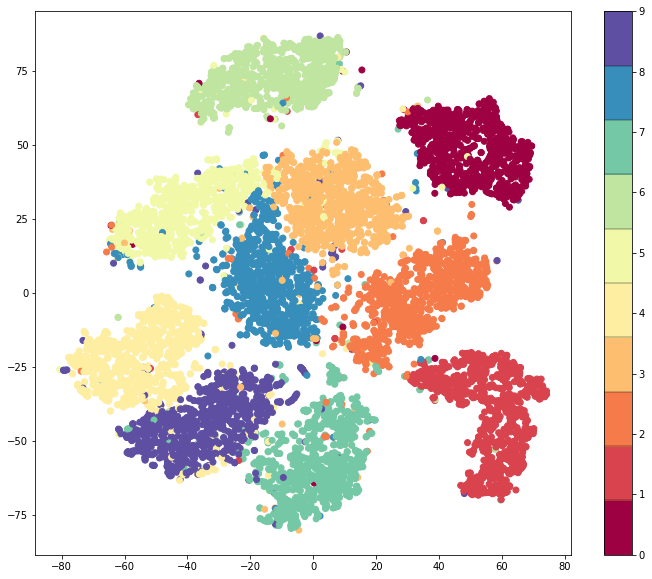

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
clustered = tsne.fit_transform(latent_vectors_cat)

fig = plt.figure(figsize=(12, 10))
cmap = plt.get_cmap("Spectral", 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

What does this plot tell us?

* It shows that using a latent space of higher dimension, there is less overlap in digits' latent space
* It also tells us that these digits' distribution of latent space is discreet and has no boundary. Meaning that the range of values of these embeddings is not continuous
    * embedding values for 0 share a range between 0 to 20
    * embedding values for 1 share a range between -40 to -60
    * there can be areas in between that choosing a sample from it may result in a distorted image that is neither 1 or 0

We can prove this by adding some noise to these embeddings and trying to regenerate images from them.

In [24]:
# step 1: transpose to get 50 embeddings with 10000 features
# len(latent_vectors_transpose) = 50

latent_vectors_transpose = latent_vectors_cat.transpose(1, 0)
latent_vectors_cat.shape, latent_vectors_transpose.shape

((10000, 50), (50, 10000))

In [25]:
# step 2: add some noise.
# take each row, calucate mean and std
# use mean and std to generate 100 new features. each time add some noise to std

rand_vectors = []  # randomized latent vectors
for col in latent_vectors_transpose:
    mu, sigma = col.mean(), col.std()
    rand_vectors.append(sigma * torch.randn(1, 100) + mu)

In [26]:
# step 3: verify dimensions

len(rand_vectors), rand_vectors[0].shape, torch.cat(rand_vectors).shape

(50, torch.Size([1, 100]), torch.Size([50, 100]))

In [27]:
# step 4: concat 100 features

rand_vectors_cat = torch.cat(rand_vectors)
rand_vectors_cat.shape

torch.Size([50, 100])

In [28]:
# step 5: transpose back to have 100 embeddings of dimension 50

rand_vectors_transpose = rand_vectors_cat.transpose(1, 0)
rand_vectors_cat.shape, rand_vectors_transpose.shape

(torch.Size([50, 100]), torch.Size([100, 50]))

We have generated 100 new (random) embeddings by adding some noise to the original embeddings. We have done it in a way so that these embeddings do not represent any digit. They are like a mix of embeddings of all the numbers. So when we try to use them, they will generate distorted images. Similar to decoded images generated by taking a sample from an overlapping latent space.

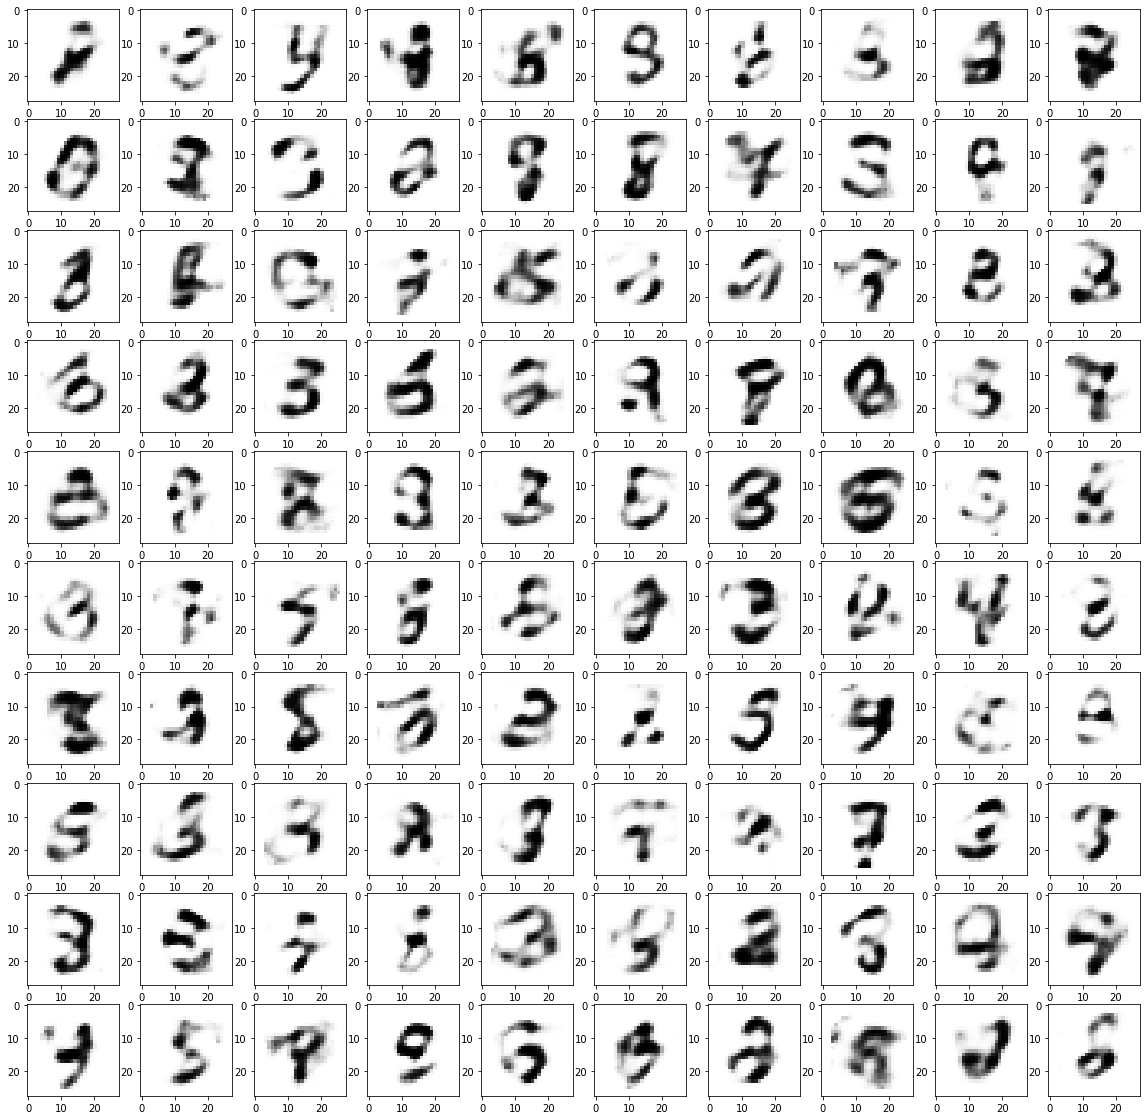

In [29]:
rand_vectors_transpose = rand_vectors_transpose.to(device)

fig, ax = plt.subplots(10, 10, figsize=(20, 20))
ax = iter(ax.flat)
for idx, rand_latent_vector in enumerate(rand_vectors_transpose):
    decoded_img = model_50.decoder(rand_latent_vector)
    decoded_img = torch.sigmoid(decoded_img)
    decoded_img = decoded_img.view(28, 28)
    decoded_img = decoded_img.detach().to(torch.device("cpu"))
    ax[idx].imshow(decoded_img, cmap="binary")

What does this plot tell us? It shows that the latent space of the (vanilla) autoencoder is restricted to specific ranges and has discrete values. Therefore, we cannot use any value from latent space to generate an image. It can be a problem since it is difficult to know an autoencoder's range of latent space beforehand, making them less useful for image generation. 

An improvement on this is `variational autoencoders (VAE)`, where the latent space is continuous and follows normal distribution making them more useful for image generation.

`chatGPT prompt > compare the latent space of VAE with traditional autoencoder`

The latent space of a VAE is continuous, whereas the latent space of a traditional autoencoder is typically discrete. This means that in a VAE, the latent representation of the data can take on any value in a continuous range, whereas in a traditional autoencoder, the latent representation is restricted to a set of discrete values.

This has several implications:

1. A continuous latent space allows a VAE to capture more fine-grained variations in the data, which can be useful for tasks such as image generation.
2. It allows the VAE to produce more diverse outputs, which can be beneficial for tasks such as anomaly detection.
3. It makes the VAE more flexible and easier to train, since it can capture complex distributions in the data.

Overall, the continuous latent space of a VAE is one of its key advantages over traditional autoencoders.